Install the packages required



In [1]:
!pip install pydot --quiet
!pip install transformers --quiet
!pip install sentencepiece --quiet
!pip install nltk --quiet
!pip install torch --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 3.6 MB/s eta 0:00:00


In [2]:
# standard
import numpy as np
import pandas as pd


import sklearn as sk
from sklearn.feature_extraction.text import CountVectorizer
import os
import nltk
from nltk.data import find

import matplotlib.pyplot as plt

import re
import string
import seaborn as sns
import os
import textwrap


import copy

from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

import transformers
from transformers import (
    T5Tokenizer, 
    T5Model,
    T5ForConditionalGeneration,
    get_linear_schedule_with_warmup
)




In [3]:
df_train = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/train_data.csv")

df_valid = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/validation_data.csv")

df_test = pd.read_csv("https://adamhyman-public.s3.amazonaws.com/w266/for_modeling/test_data.csv")

In [4]:
df_train = df_train.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
#There are 3 null comments in train dataset, 1 in valid and 1 in test. They need to be removed or we get error.
df_train = df_train.dropna(how='any',axis=0).reset_index(drop=True)
df_valid = df_valid.dropna(how='any',axis=0).reset_index(drop=True)
df_test = df_test.dropna(how='any',axis=0) .reset_index(drop=True)


df_train = df_train[df_train["comment_text"] != '']
df_valid = df_valid[df_valid["comment_text"] != '']
df_test = df_test[df_test["comment_text"] != '']

df_train = df_train.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
df_valid = df_valid.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})
df_test = df_test.astype({'toxic':'int', 'severe_toxic':'int', 'obscene':'int', 'threat':'int', 'insult':'int', 'identity_hate':'int'})

In [5]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"\#/@;:{}`+=~|!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\W)"," ",text) 

    return text
df_train["text"] = df_train['comment_text'].apply(lambda text: clean_text(text))
df_valid["text"] = df_valid['comment_text'].apply(lambda text: clean_text(text))
df_test["text"] = df_test['comment_text'].apply(lambda text: clean_text(text))


In [6]:
train_comments, train_labels = df_train["text"], df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
valid_comments, valid_labels = df_valid["text"], df_valid[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test_comments, test_labels = df_test["text"], df_test[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [7]:
def get_labels(df):
    labels_li = [' '.join(x.lower().split()) for x in df.columns.to_list()[:6]]
    labels_matrix = np.array([labels_li] * len(df))

    mask = df.iloc[:, :6].values.astype(bool)
    labels = []
    for l, m in zip(labels_matrix, mask):
        x = l[m]
        if len(x) > 0:
            labels.append(' , '.join(x.tolist()) + ' </s>')
        else:
            labels.append('none </s>')
    return labels

def get_texts(df):
    texts = 'multilabel classification: ' + df
    
    return texts


In [8]:

texts = get_texts(train_comments)
labels = get_labels(train_labels)


for text, label in zip(texts[854:860], labels[854:860]):
     print(f'TEXT -\t{text}')
     print(f'LABEL -\t{label}')
     print()

val_texts = get_texts(valid_comments)
val_labels = get_labels(valid_labels)


for text, label in zip(val_texts[854:860], val_labels[854:860]):
     print(f'val TEXT -\t{text}')
     print(f'val LABEL -\t{label}')
     print()
# print(type(train_comments))


TEXT -	multilabel classification: frankly errant you are a bit of a dick ban me from wikipedia or whatever for saying that i do not care
LABEL -	toxic , obscene , insult </s>

TEXT -	multilabel classification:    hiroshima august 6 and august 9 1945   i have once again removed the statement operation suspended 6 august 1945 because of damage caused by atomic bomb attack service restored in stages from 9 august 1945 the cited reference does not address this  the august 6 1945 date is undoubtedly correct however absent a reference with citation perhaps even a brief footnoted explanation the statement that service restored in stages from 9 august 1945 does not belong absent a reference the statement is fanciful indeed preposterous and has the distinct cachet of an urban legend once again please see wpproveit please see in addition wpredflag although not quite a fringe theory this is obviously an exceptional claim that requires a highquality reliable source  a published reference in japane

['severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


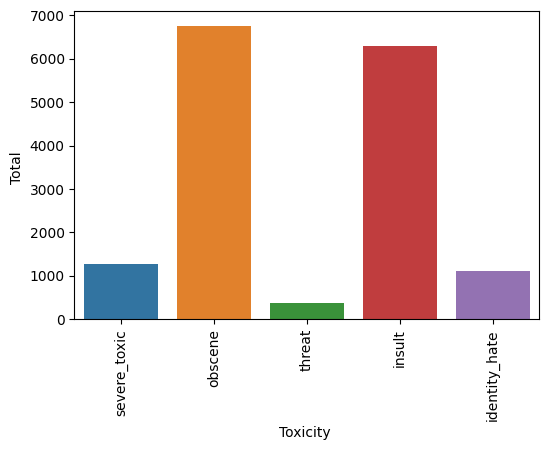

In [9]:
categories = df_train.columns.to_list()[3:8]
plt.figure(figsize=(6, 4))
print(categories)

ax = sns.barplot(x=categories, y=df_train.iloc[:, 3:8].sum().values)
plt.ylabel('Total ')
plt.xlabel('Toxicity ')
plt.xticks(rotation=90)
plt.show()

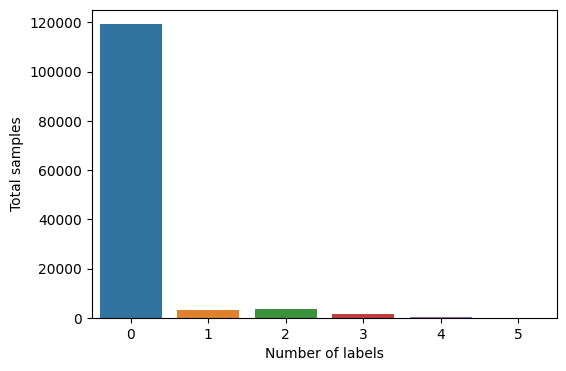

In [10]:
# no of samples having multiple labels
row_sums = df_train.iloc[:, 3:8].sum(axis=1)
multilabel_counts = row_sums.value_counts()

plt.figure(figsize=(6, 4))
ax = sns.barplot(x=multilabel_counts.index, y=multilabel_counts.values)
plt.ylabel('Total samples')
plt.xlabel('Number of labels')
plt.show()

Feed the large T5 dataset

In [11]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 't5-base'

        # data
        self.TOKENIZER = T5Tokenizer.from_pretrained(self.MODEL_PATH)
        self.SRC_MAX_LENGTH = 320
        self.TGT_MAX_LENGTH = 20
        self.BATCH_SIZE = 16
        self.VALIDATION_SPLIT = 0.25

        # model
        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.SAVE_BEST_ONLY = True
        self.N_VALIDATE_DUR_TRAIN = 3
        self.EPOCHS = 2

config = Config()

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [12]:
class T5Dataset(Dataset):
    def __init__(self, df, texts, labels, indices, set_type=None):
        super(T5Dataset, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(texts)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(labels)

        self.tokenizer = config.TOKENIZER
        self.src_max_length = config.SRC_MAX_LENGTH
        self.tgt_max_length = config.TGT_MAX_LENGTH

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):

        src_tokenized = self.tokenizer.encode_plus(
            self.texts[index], 
            max_length=self.src_max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        src_input_ids = src_tokenized['input_ids'].squeeze()
        src_attention_mask = src_tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            tgt_tokenized = self.tokenizer.encode_plus(
                self.labels[index], 
                max_length=self.tgt_max_length,
                pad_to_max_length=True,
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            tgt_input_ids = tgt_tokenized['input_ids'].squeeze()
            tgt_attention_mask = tgt_tokenized['attention_mask'].squeeze()

            return {
                'src_input_ids': src_input_ids.long(),
                'src_attention_mask': src_attention_mask.long(),
                'tgt_input_ids': tgt_input_ids.long(),
                'tgt_attention_mask': tgt_attention_mask.long()
            }

        return {
            'src_input_ids': src_input_ids.long(),
            'src_attention_mask': src_attention_mask.long()
        }

In [13]:

train_data = T5Dataset(df_train, train_comments, train_labels, len(train_comments)-1)

val_data = T5Dataset(df_valid, valid_comments, valid_labels, len(valid_comments)-1)



In [14]:
train_dataloader = DataLoader(train_data, batch_size=config.BATCH_SIZE)
val_dataloader = DataLoader(val_data, batch_size=config.BATCH_SIZE)
print(val_dataloader)
b = next(iter(train_dataloader))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

src_input_ids shape: torch.Size([16, 320])
src_attention_mask shape: torch.Size([16, 320])
tgt_input_ids shape: torch.Size([16, 20])
tgt_attention_mask shape: torch.Size([16, 20])


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


In [15]:
class T5Model(nn.Module):
    def __init__(self):
        super(T5Model, self).__init__()

        self.t5_model = T5ForConditionalGeneration.from_pretrained(config.MODEL_PATH)

    def forward(
        self,
        input_ids, 
        attention_mask=None, 
        decoder_input_ids=None, 
        decoder_attention_mask=None, 
        labels=None
        ):

        return self.t5_model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )


In [16]:
print(config.DEVICE)
device = config.DEVICE

cuda


In [17]:
def get_ohe(x):
    labels_li = ['_'.join(x.lower().split()) for x in df_train.columns.to_list()[3:8]]
    labels_li_indices = dict()
    for idx, label in enumerate(labels_li):
        labels_li_indices[label] = idx
        
    y = [labels.split(', ') for labels in x]
    ohe = []
    for labels in y:
        temp = [0] * 6
        for label in labels:
            idx = labels_li_indices.get(label, -1)
            if idx != -1:
                temp[idx] = 1
        ohe.append(temp)
    ohe = np.array(ohe)
    return ohe

In [18]:
def val(model, val_dataloader, criterion):
    
    val_loss = 0
    true, pred = [], []
    
    # set model.eval() every time during evaluation
    model.eval()
    
    for step, batch in enumerate(val_dataloader):
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        b_tgt_input_ids = batch['tgt_input_ids']
        labels = b_tgt_input_ids.to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # using torch.no_grad() during validation/inference is faster -
        # - since it does not update gradients.
        with torch.no_grad():
            # forward pass
            outputs = model(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask,
                labels=labels,
                decoder_attention_mask=b_tgt_attention_mask)
            loss = outputs[0]

            val_loss += loss.item()

            # get true 
            for true_id in b_tgt_input_ids:
                true_decoded = config.TOKENIZER.decode(true_id)
                true.append(true_decoded)

            # get pred (decoder generated textual label ids)
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    true_ohe = get_ohe(true)
    pred_ohe = get_ohe(pred)

    avg_val_loss = val_loss / len(val_dataloader)
    print('Val loss:', avg_val_loss)
    print('Val accuracy:', accuracy_score(true_ohe, pred_ohe))

    val_micro_f1_score = f1_score(true_ohe, pred_ohe, average='micro')
    print('Val micro f1 score:', val_micro_f1_score)
    return val_micro_f1_score


def train(
    model,  
    train_dataloader, 
    val_dataloader, 
    criterion, 
    optimizer, 
    scheduler, 
    epoch
    ):
    
    # we validate config.N_VALIDATE_DUR_TRAIN times during the training loop
    nv = config.N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]
    
    train_loss = 0
    for step, batch in enumerate(tqdm(train_dataloader, 
                                      desc='Epoch ' + str(epoch))):
        # set model.eval() every time during training
        model.train()
        
        # unpack the batch contents and push them to the device (cuda or cpu).
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)
    
        labels = batch['tgt_input_ids'].to(device)
        labels[labels[:, :] == config.TOKENIZER.pad_token_id] = -100

        b_tgt_attention_mask = batch['tgt_attention_mask'].to(device)

        # clear accumulated gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(input_ids=b_src_input_ids, 
                        attention_mask=b_src_attention_mask,
                        labels=labels,
                        decoder_attention_mask=b_tgt_attention_mask)
        loss = outputs[0]
        train_loss += loss.item()

        # backward pass
        loss.backward()

        # update weights
        optimizer.step()
        
        # update scheduler
        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)
    
    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [19]:
def run():
    # setting a seed ensures reproducible results.
    # seed may affect the performance too.
    torch.manual_seed(config.SEED)

    criterion = nn.BCEWithLogitsLoss()
    
    # define the parameters to be optmized -
    # - and add regularization
    if config.FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=config.LR)

    num_training_steps = len(train_dataloader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_micro_f1_score = float('-inf')
    for epoch in range(config.EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_micro_f1_score = val(model, val_dataloader, criterion)

        if config.SAVE_BEST_ONLY:
            if val_micro_f1_score > max_val_micro_f1_score:
                best_model = copy.deepcopy(model)
                best_val_micro_f1_score = val_micro_f1_score

                model_name = 't5_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val loss: {max_val_micro_f1_score} -> {val_micro_f1_score}')
                max_val_micro_f1_score = val_micro_f1_score

    return best_model, best_val_micro_f1_score

In [20]:
model = T5Model()
model.to(device);

In [21]:
best_model, best_val_micro_f1_score = run()


Epoch 0:  33%|███▎      | 2600/7979 [13:00<26:55,  3.33it/s]

-- Step: 2600


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  33%|███▎      | 2601/7979 [24:28<308:34:38, 206.56s/it]

Val loss: 0.11016401703197236
Val accuracy: 0.9559754339788181
Val micro f1 score: 0.5955346650998824


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0:  65%|██████▌   | 5200/7979 [37:26<14:02,  3.30it/s]

-- Step: 5200


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  65%|██████▌   | 5201/7979 [48:35<154:56:42, 200.79s/it]

Val loss: 0.0934083165868301
Val accuracy: 0.9623676129598295
Val micro f1 score: 0.6523627075351214


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0:  98%|█████████▊| 7800/7979 [1:01:33<00:53,  3.37it/s]

-- Step: 7800


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 0:  98%|█████████▊| 7801/7979 [1:12:43<9:56:51, 201.19s/it]

Val loss: 0.09002720281229509
Val accuracy: 0.9654696998182616
Val micro f1 score: 0.6795327577450482


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 0: 100%|██████████| 7979/7979 [1:13:36<00:00,  1.81it/s]
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is depre

Training loss: 0.1503960378410916
Val loss: 0.09044771225316821
Val accuracy: 0.9649370182365106
Val micro f1 score: 0.6652542372881356
--- Best Model. Val loss: -inf -> 0.6652542372881356


Epoch 1:   0%|          | 0/7979 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  33%|███▎      | 2600/7979 [12:58<26:52,  3.34it/s]

-- Step: 2600


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  33%|███▎      | 2601/7979 [24:44<316:40:43, 211.98s/it]

Val loss: 0.09054920565251455
Val accuracy: 0.9601115497900607
Val micro f1 score: 0.6671195652173914


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  65%|██████▌   | 5200/7979 [37:42<13:57,  3.32it/s]

-- Step: 5200


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  65%|██████▌   | 5201/7979 [49:24<162:32:15, 210.63s/it]

Val loss: 0.0875827086538343
Val accuracy: 0.9618662655887699
Val micro f1 score: 0.6769870609981515


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1:  98%|█████████▊| 7800/7979 [1:02:22<00:53,  3.36it/s]

-- Step: 7800


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Epoch 1:  98%|█████████▊| 7801/7979 [1:13:52<10:14:29, 207.13s/it]

Val loss: 0.08438277848365858
Val accuracy: 0.9652190261327317
Val micro f1 score: 0.6842366981601193


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:226: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
Epoch 1: 100%|██████████| 7979/7979 [1:14:46<00:00,  1.78it/s]
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is depre

Training loss: 0.09169130029765742
Val loss: 0.08446814085070667
Val accuracy: 0.9651876919220405
Val micro f1 score: 0.6837267080745342
--- Best Model. Val loss: 0.6652542372881356 -> 0.6837267080745342


In [22]:
test_data = T5Dataset(df_test, test_comments, test_labels, len(test_comments)-1, set_type = 'test')

test_dataloader = DataLoader(test_data, batch_size=config.BATCH_SIZE)


In [23]:
def predict(model):
    val_loss = 0
    pred = []
    model.eval()
    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        b_src_input_ids = batch['src_input_ids'].to(device)
        b_src_attention_mask = batch['src_attention_mask'].to(device)

        with torch.no_grad():
            # get pred
            pred_ids = model.t5_model.generate(
                input_ids=b_src_input_ids, 
                attention_mask=b_src_attention_mask
            )
            pred_ids = pred_ids.cpu().numpy()
            for pred_id in pred_ids:
                pred_decoded = config.TOKENIZER.decode(pred_id)
                pred.append(pred_decoded)

    pred_ohe = get_ohe(pred)
    return pred_ohe

pred_ohe = predict(best_model)

  0%|          | 0/3999 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 3999/3999 [18:09<00:00,  3.67it/s]


In [24]:
print(best_val_micro_f1_score)
print(pred_ohe)
y_test = test_labels
y_test_pred = np.where(pred_ohe>=0.5, 1, 0)
y_test_pred[:10] 

0.6837267080745342
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]]


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [25]:
print(pred_ohe)
print(type(pred_ohe))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 1 0 1 0 0]
 [0 0 0 0 0 0]]
<class 'numpy.ndarray'>


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'], zero_division = 0))

               precision    recall  f1-score   support

        toxic       0.98      0.08      0.14      6090
 severe_toxic       0.09      0.95      0.16       367
      obscene       0.82      0.03      0.05      3691
       threat       0.06      0.18      0.09       211
       insult       0.82      0.00      0.01      3427
identity_hate       0.00      0.00      0.00       712

    micro avg       0.18      0.07      0.10     14498
    macro avg       0.46      0.21      0.07     14498
 weighted avg       0.82      0.07      0.08     14498
  samples avg       0.01      0.00      0.00     14498



In [27]:
from sklearn.metrics import hamming_loss
hamming_loss(y_test, y_test_pred)

0.0467444090122762

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_test_pred, average=None)


array([0.53868295, 0.94605305, 0.51256779, 0.58508354, 0.50129659,
       0.5       ])

In [29]:
roc_auc_score(y_test, y_test_pred, average="macro")

0.5972806523633647